# Fitting Univariate Distributions

*Purpose*: 


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

For this exercise, we'll study a dataset of observations on die cast aluminum parts.


In [2]:
from grama.data import df_shewhart


# Why fit a distribution?

(We fit a distribution to model variability)


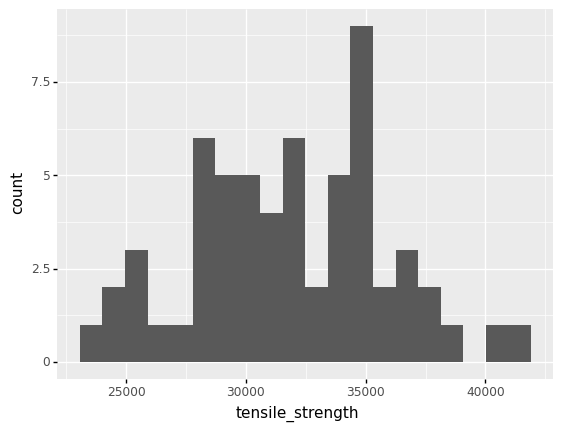

<ggplot: (8762646263754)>

In [3]:
# NOTE: No need to edit; run and inspect
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram(bins=20)
)

## Dangers of assuming the mean

Why don't we just take the mean of `tensile_strength` and use that for design? It turns out this approach is *very dangerous* when safety is a consideration. Let's take a look at the tensile strength of an aluminum alloy.


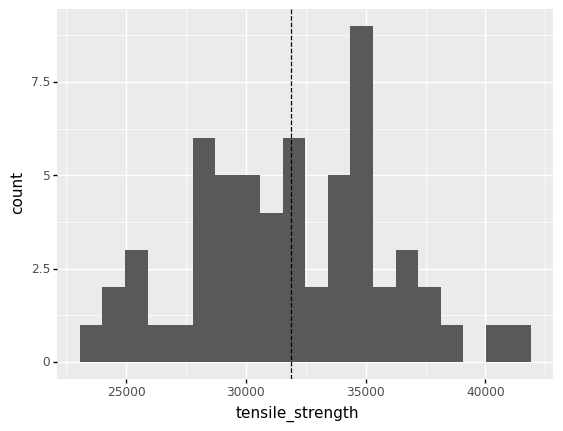

<ggplot: (8762646512460)>

In [4]:
# NOTE: No need to edit; run and inspect
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram(bins=20)
    + gr.geom_vline(
        data=df_shewhart
        >> gr.tf_summarize(tensile_strength=gr.mean(DF.tensile_strength)),
        mapping=gr.aes(xintercept="tensile_strength"),
        linetype="dashed",
    )
)

Clearly, values of `tensile_strength` tend to land both above and below the mean. But what ramifications does this have for engineering design?


### __qX__ What fraction of `tensile_strength` is below the mean?

Compute the fraction of observations in `df_shewhart` where `tensile_strength < mean(tensile_strength)`. Answer the questions under *observations* below.


In [5]:
(
    df_shewhart
    >> gr.tf_summarize(
        frac=gr.pr(DF.tensile_strength < gr.mean(DF.tensile_strength))
    )
)

,frac
0,0.5


*Observations*

For these questions, assume the variability in `tensile_strength` is real; that is, the variability is not simply due to measurement error.

- What fraction of observations have `tensile_strength < mean(tensile_strength)`?
  - I find that `frac == 0.5` (i.e. 50%)
- Suppose a design assumed `mean(tensile_strength)` as the design stress; that is, every part would be subject to a stress equal to `mean(tensile_strength)`. The fraction you computed above would be the fraction of parts that would fail. Would this failure rate be acceptable for any engineering system involving human safety?
  - Absolutely not; a failure rate of 50% would be completely unacceptable for any application involving human safety.


## Random variables

Clearly `tensile_strength` does not take a single value; therefore, we should think of `tensile_strength` as a *random variable*. A random variable is a mathematical object that we can use to model an uncertain quantity. Unlike a *deterministic variable* that has one fixed value (say $x = 1$), a random variable can take a different value each time we *observe* it. For instance, if $X$ were a random variable, and we used $X_i$ to denote the value that occurs on the $i$-th observation, then we might see a sequence like

$$X_1 = 1, X_2 = -3, X_3 = 1, X_4 = 5, \dots$$

What counts as an *observation* depends on what we are using the random variable to model. Essentially, an observation is an occurrence that gives us the potential to "see" a new value. 

Let's take a look at the `tensile_strength` example to get a better sense of these ideas.


For the `tensile_strength`, we saw a sequence of different values:

In [6]:
(
    df_shewhart
    >> gr.tf_head(4)
)

,specimen,tensile_strength,hardness,density
0,1,29314,53.0,2.666
1,2,34860,70.2,2.708
2,3,36818,84.3,2.865
3,4,30120,55.3,2.627


Every time we manufacture a new part, we perform a sequence of manufacturing steps that work together to "lock in" a particular value of `tensile_strength`. Those individual steps tend to go slightly differently each time we make a part (e.g. an operator calls in sick one day, we get a slightly more dense batch of raw material, it's a particularly hot summer day, etc.), so we end up with different properties in each part.

Given the complicated realities of manfacturing, it makes sense to think of an *observation* as being one complete run of the manufacturing process that generates a particular part with its own `tensile_strength`. This is what the `specimen` column in `df_shewhart` refers to; a unique identifier tracking individual runs of the complete manufacturing process, resulting in a unique part.


```{admonition} Nomenclature: A *realization* is like a single roll of a die
Some nomenclature: When we talk about random quantities, we use the term *realization* (or *observation*) to refer to a single event that yields a random value, according to a particular distribution. For instance, a single manufactured part will have a realized strength value. If we take multiple realizations, we will tend to see different values. For instance, we saw a large amount of variability among the realized `tensile_strength` values above.

A single realization tells us very little about how the distribution tends to behave, but a set of realizations (a *sample*) will give us a sense of how the random values tend to behave *collectively*. A distribution is a way to model that collective behavior.
```

## A distribution defines a random variable

As we saw in `e-stat04-distributions`, we can use distributions to quantitatively describe an uncertain quantity. **A distribution defines a random variable**. We say that a random variable $X$ is *distributed according to* a particular density $\rho$, and we express the same statement mathematically as

$$X \sim \rho.$$

We learned how to compute useful quantities using distributions in `e-stat04-distributions`; in the rest of this exercise, we'll learn how to *fit* a distribution in order use information from a dataset to model observations from the physical world.


# The steps to fitting

1. Check for *statistical control*
2. Select candidate distributions
3. Fit and assess


# Check for *statistical control*



### __qX__ Make a histogram of the `tensile_strength`


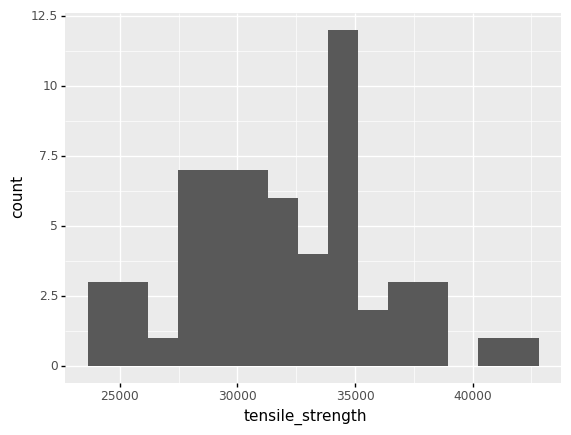

<ggplot: (8762646489266)>

In [7]:
## TASK:
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram(bins=15)
)
# solution-end

*Observations*



*Note*: To help with the next task, it will be helpful to know about the *integer division* operator `//`. This divides by a desired value, but rounds down to the nearest integer.


In [8]:
print("1 // 4 = {}".format(1 // 4))
print("2 // 4 = {}".format(2 // 4))
print("3 // 4 = {}".format(3 // 4))
print("4 // 4 = {}".format(4 // 4))
print("5 // 4 = {}".format(5 // 4))

1 // 4 = 0
2 // 4 = 0
3 // 4 = 0
4 // 4 = 1
5 // 4 = 1


## Control charts

TODO

- By taking *batch means*, we can use the central limit theorem to make quantitative, statistical statements about the observations.
- By taking *small* batches, we can attribute strange patterns to a small number of observations. This gives us somewhere to look if we detect strange behavior.

The following is an example of a control chart: The points are batch means, the solid horizontal line is the mean of all observations, and the dashed lines are the *control limits* (discussed below). With this chart, we can look for various kinds of patterns:


![Example control chart demonstrating two kinds of patters: a batch mean that exceeds the control limits, and a "run" of batch means that lies to one side of the grand mean.](images/control-chart.png)


Some patterns illustrated above:

- Outliers: The control limits (dashed lines) are constructed such that about one batch mean in a thousand should lie outside the limits. Batch means that exceed the limits are therefore suspicious, and worth investigating further.
- Off-center runs: Batch means should be distributed roughly equally above and below the grand mean (solid line). A sequence (a "run") of batch means that lie all above (or all below) the grand mean are therefore suspicious, and worth investigating further.


If you detect suspicious patterns using a control chart, then there is evidence that the process being studied is *not* under statistical control. The batches associated with suspicious behavior should then be investigated in further detail, in order to hunt down and eliminate any assignable cause(s) of variability.

If you *do not* detect suspicious patterns, then you can *provisionally* state that the process is under statistical control. A quantity under statistical control can be treated as random, which will endorse modeling that quantity with a distribution.


### __qX__ Add a group identifier

Create a group identifier column `id_group` that assigns observations to consecutive groups of four. Make sure the first group identifier is `0`, and use sequential integers.


In [9]:
## TODO: Create a group identifier column to make
# batches of 4 consecutive values
n_grp = 4

df_rolling = (
    df_shewhart

    >> gr.tf_mutate(id_group=DF.index // n_grp)
)

## NOTE: Don't edit the following; use this to check your work
assert \
    "id_group" in df_rolling.columns, \
    "df_rolling missing the id_group column"

assert \
    all(df_rolling.id_group[:8] == [0]*4 + [1]*4), \
    "The id_group column is incorrect; " + \
    "the first 8 values should be 0, 0, 0, 0, 1, 1, 1, 1"


### __qX__ Compute the batch means

Compute the mean within each consecutive "batch" of observations.


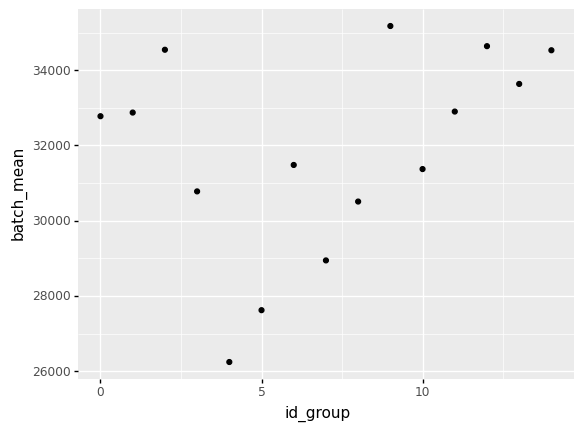

<ggplot: (8762646969314)>

In [10]:
## TASK: Compute the `batch_mean` within 
# each group of observations
df_batches = (
    df_rolling

    >> gr.tf_group_by(DF.id_group)
    >> gr.tf_summarize(
        batch_mean=gr.mean(DF.tensile_strength)
    )
)

## NOTE: Don't edit the following; use this to check your work
assert \
    df_batches.shape[0] == (df_shewhart.shape[0] / n_grp), \
    "Size of df_batches is incorrect; " + \
    "make sure you grouped properly."

(
    df_batches
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_point()
)

## Control limits

Remember from the Monte Carlo exercise that a confidence interval for the mean can be approximated using the central limit theorem via

$$[\hat{\mu} - q \hat{\sigma} / \sqrt{n}, \hat{\mu} + q \hat{\sigma} / \sqrt{n}],$$

where $\hat{\mu}$ is the sample mean, $\hat{\sigma}$ is the sample standard deviation, and $n$ is the number of samples used to compute $\hat{\mu}$.


In [11]:
# NOTE: No need to edit; this computes the probability of
# finding a batch mean outside the control limits
mg_norm = gr.marg_mom("norm", mean=0, sd=1)
mg_norm.p(-3) * 2


0.0026997960632601866

In [12]:
# NOTE: No need to edit
df_stats = (
    df_shewhart
    >> gr.tf_summarize(
        tys_mean=gr.mean(DF.tensile_strength),
        tys_sd=gr.sd(DF.tensile_strength),
        n=gr.n(DF.tensile_strength),
    )
)
df_stats


,tys_mean,tys_sd,n
0,31869.366667,3996.380795,60


### __qX__ Compute the control limits

Compute the control limits for the batch means. Use a multiplier of $q = 3$. Answer the questions under *observations* below.


0    37863.937859
Name: tys_hi, dtype: float64


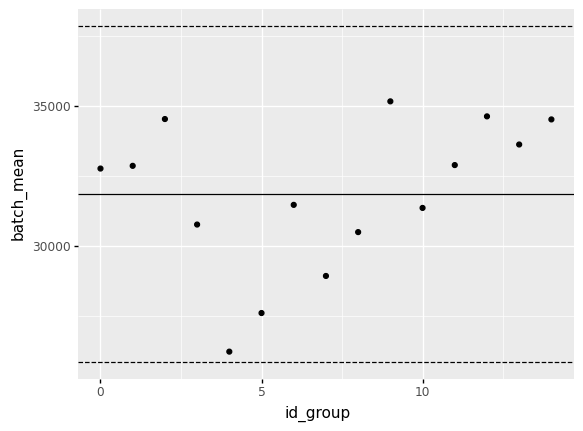

<ggplot: (8762646972895)>

In [13]:
df_limits = (
    df_stats
    >> gr.tf_mutate(
        tys_lo=DF.tys_mean - 3 * DF.tys_sd / gr.sqrt(n_grp),
        tys_hi=DF.tys_mean + 3 * DF.tys_sd / gr.sqrt(n_grp),
    )
)

## NOTE: Don't edit the following; use this to check your work
print(df_limits.tys_hi)
assert \
    all(abs(df_limits.tys_lo - 25874.795475) < 1e-2), \
    "Lower control limit is incorrect; " + \
    "did you use the same sample size used to compute " + \
    "the batch means?"
assert \
    all(abs(df_limits.tys_hi - 37863.937859) < 1e-2), \
    "Upper control limit is incorrect; " + \
    "did you use the same sample size used to compute " + \
    "the batch means?"

(
    df_batches
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_lo"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_hi"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_mean"),
    )
    + gr.geom_point()
)

*Observations*



## Vary the batch size

As with adjusting the bin size of a histogram, it is also important to test different batch sizes with a control chart. The following re-constructs the control chart, but with a slightly smaller batch size:


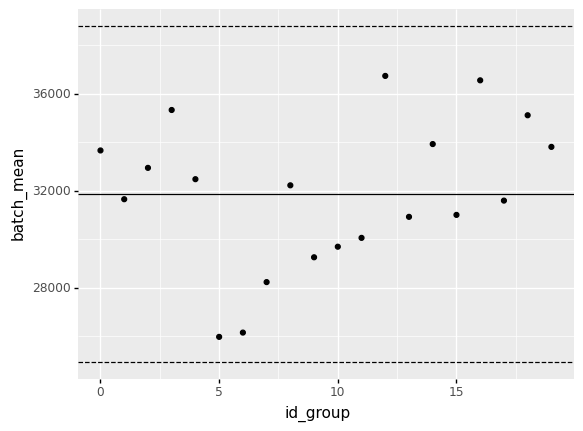

<ggplot: (8762646205471)>

In [14]:
# NOTE: No need to edit this
n_temp = 3

(
    df_shewhart
    >> gr.tf_mutate(id_group=DF.index // n_temp)
    >> gr.tf_group_by(DF.id_group)
    >> gr.tf_summarize(batch_mean=gr.mean(DF.tensile_strength))
    
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_hline(
        df_stats
        >> gr.tf_mutate(
            y=DF.tys_mean - 3 * DF.tys_sd / gr.sqrt(n_temp)
        ),
        gr.aes(yintercept="y"),
        linetype="dashed",
    )
    + gr.geom_hline(
        df_stats
        >> gr.tf_mutate(
            y=DF.tys_mean + 3 * DF.tys_sd / gr.sqrt(n_temp)
        ),
        gr.aes(yintercept="y"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_stats,
        mapping=gr.aes(yintercept="tys_mean"),
    )
    + gr.geom_point()
)

Here we see reasonably similar behavior with no violations of the control limits and no suspicious patterns. The data from this process appear to be under statistical control. Thus, we can proceed with modeling the `tensile_strengh` as a random quantity.


# Select candidate distributions


## (Short) list of distributions

| Distribution | Name | Description |
|---|---|---|
| Normal (Gaussian) | `"norm"` | Symmetric; infinite extent |
| Lognormal | `"lognormal"` | Asymmetric; positive |
| Uniform | `"uniform"` | Bounded, flat |
| Beta | `"beta"` | Bounded, flexible shape |
| Weibull | `"weibull_min"` | Asymmetric; positive |

For a longer list of supported distributions, see the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/stats.html) for continuous distributions.


### __qX__ Select reasonable distributions for `tensile_strength`

TODO - conceptual question


# Fit and assess


## Grama tools for fitting

TODO

| Verb | Purpose |
|------|---------|
| `gr.marg_mom()` | Fit a distribution based on a handful of statistics, e.g. mean and variance |
| `gr.marg_fit()` | Fit a distribution using multiple observations, e.g. `df_shewhart.tensile_strength` |


### __qX__ Fit a normal distribution

Complete the arguments for both `gr.marg_mom()` and `gr.marg_fit()` below to fit a normal distribution for the `tensile_strength`.

*Hint 1*: Remember the table above that lists the string names for a set of distributions.

*Hint 2*: Remember to use the documentation to learn how to call a new function!


In [15]:
## TASK: Complete the arguments for the two functions below
mg_mom = gr.marg_mom(

    "norm", 
    mean=df_shewhart.tensile_strength.mean(),
    var=df_shewhart.tensile_strength.var(),
)

mg_fit = gr.marg_fit(

    "norm",
    df_shewhart.tensile_strength,
)

## NOTE: No need to edit; this will run when you complete the task
print(mg_mom)
print(mg_fit)

(+0) norm, {'mean': '3.187e+04', 's.d.': '3.996e+03', 'COV': 0.13, 'skew.': 0.0, 'kurt.': 3.0}
(+0) norm, {'mean': '3.187e+04', 's.d.': '3.963e+03', 'COV': 0.12, 'skew.': 0.0, 'kurt.': 3.0}


## QQ plots

TODO


### __qX__ Inspect this QQ plot

TODO


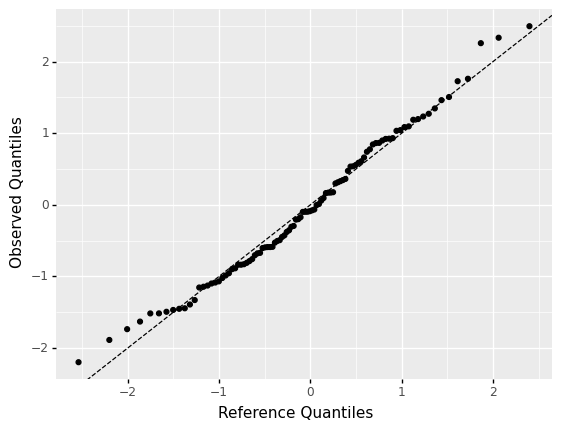

<ggplot: (8762646346650)>

In [16]:
## NOTE: No need to edit; run and inspect
# Define a standard normal distribution
mg_norm = gr.marg_mom("norm", mean=0, sd=1)

(
    # Draw some random values
    gr.df_make(z=mg_norm.r(100))
    # Compute theoretical quantiles based on fitted normal
    >> gr.tf_mutate(q=gr.qqvals(DF.z, "norm"))
    
    # Visualize
    >> gr.ggplot(gr.aes("q", "z"))
    # Add a guideline
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    
    + gr.geom_point()
    + gr.labs(x="Reference Quantiles", y="Observed Quantiles")
)

*Observations*



### __qX__ Fit a distribution for the `tensile_strength`

Pick a distribution from the list of "reasonable" distributions you generated in `__qX__ Select reasonable distributions`, and fit a distribution for `df_shewhart.tensile_strength`. Answer the questions under *observations* below.

*Hint*: If you choose to fit a `"lognorm"` or `"weibull_min"`, you may find it helpful to set the keyword argument `floc=0` to use the 2-parameter version of the distribution. Anecdotally, I find the 2-parameter version to be more stable for small datasets.


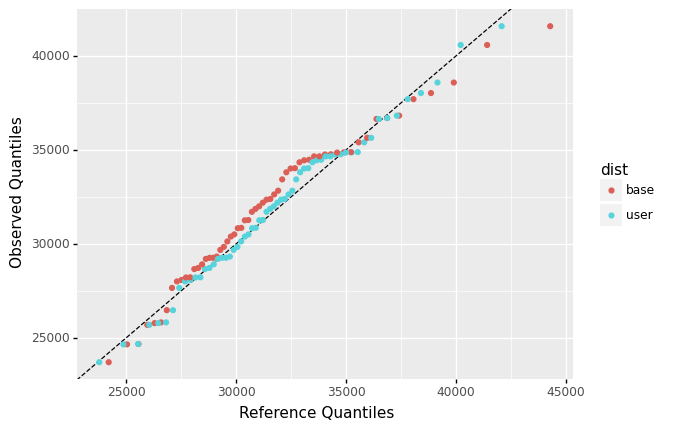

<ggplot: (8762646392314)>

In [17]:
# TASK: Fit a distribution for the tensile_strength;
# assign it to mg_user below

mg_user = gr.marg_fit(
    "lognorm", 
    df_shewhart.tensile_strength,
    floc=0,
)
# NOTE: Don't edit this; use to check your results
mg_base = gr.marg_fit(
    "gengamma",
    df_shewhart.tensile_strength,
    floc=0,
)

(
    df_shewhart
    >> gr.tf_mutate(
        q_base=gr.qqvals(DF.tensile_strength, marg=mg_base),
        q_user=gr.qqvals(DF.tensile_strength, marg=mg_user),
    )
    >> gr.tf_pivot_longer(
        columns=["q_base", "q_user"],
        names_to=[".value", "dist"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("q", "tensile_strength", color="dist"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
    + gr.labs(x="Reference Quantiles", y="Observed Quantiles")
)

*Observations*

- What distribution did you choose to fit?
  - I fit a lognormal `"lognorm"` distribution, but there are multiple reasonable choices for this question.
- How does your distribution (`user`) compare with the generalized gamma distribution (`base`)?
  - The lognormal fits a fair bit better than the generalized gamma; both the middle of the distribution and the right tail lie closer to the identity line.
<!-- solution-end -->

# Use the model

## Beyond assuming the mean

Above, we saw that simply using the mean of `tensile_strength` for design was dangerous for safety-critical applications. Let's talk about a more principled way to address the variability in `tensile_strength`.


TODO

$$g_{\text{tension}} = S - F/A$$

In [18]:
## NOTE: No need to edit
md_structure = (
    gr.Model("Uniaxial tension member")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            g_tension=df.S - df.F / df.A,
        ),
        var=["S", "F", "A"],
        out=["g_tension"],
    )
    >> gr.cp_bounds(A=(1.0, 5.0))
    >> gr.cp_marginals(
        S=mg_user,
        F=gr.marg_mom("lognorm", mean=8e4, cov=0.1, floc=0),
    )
    >> gr.cp_copula_independence()
)
md_structure

model: Uniaxial tension member

  inputs:
    var_det:
      A: [1.0, 5.0]

    var_rand:
      S: (+0) lognorm, {'mean': '3.187e+04', 's.d.': '4.019e+03', 'COV': 0.13, 'skew.': 0.38, 'kurt.': 3.26}
      F: (+0) lognorm, {'mean': '8.000e+04', 's.d.': '8.000e+03', 'COV': 0.1, 'skew.': 0.3, 'kurt.': 3.16}

    copula:
      Independence copula

  functions:
      f0: ['S', 'F', 'A'] -> ['g_tension']

### __qX__ TODO



In [19]:
(
    md_structure
    >> gr.ev_sample(n=1e3, df_det=gr.df_make(A=[2, 3, 4]))
    >> gr.tf_group_by(DF.A)
    >> gr.tf_summarize(
        pof_lo=gr.binomial_ci(DF.g_tension <= 0, alpha=0.95, side="lo"),
        pof_mu=gr.mean(DF.g_tension <= 0),
        pof_up=gr.binomial_ci(DF.g_tension <= 0, alpha=0.95, side="up"),
    )
)

eval_sample() is rounding n...


,A,pof_lo,pof_mu,pof_up
0,2,0.928489,0.929,0.929508
1,3,0.145301,0.146,0.146702
2,4,0.000000,0.000,0.000004
